In [1]:
# this code is written by Changyi Yang used for DS Discovery program

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

In [211]:
torch. __version__

'1.13.1'

In [212]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/Shareddrives/PebbleReactorProject/Data

In [213]:
test_df = pd.read_csv('binnedpebbles.csv')
test_df.head()

,t,0,1,2,3,4,5,6,7,8,...,141,142,143,144,145,146,147,148,149,keff
0,0.000000,3852,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01615
1,8.870571,3922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01598
2,17.741143,4013,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01509
3,26.611714,3971,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01539
4,35.482286,3704,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.01502


In [242]:
df = pd.read_csv('fluence.csv')
df

,t,['0.0:7.21e+18'],['7.21e+18:1.44e+19'],['1.44e+19:2.16e+19'],['2.16e+19:2.88e+19'],['2.88e+19:3.6e+19'],['3.6e+19:4.32e+19'],['4.32e+19:5.04e+19'],['5.04e+19:5.77e+19'],['5.77e+19:6.49e+19'],...,['1.38e+21:1.39e+21'],['1.39e+21:1.4e+21'],['1.4e+21:1.41e+21'],['1.41e+21:1.41e+21'],['1.41e+21:1.42e+21'],['1.42e+21:1.43e+21'],['1.43e+21:1.43e+21'],['1.43e+21:1.44e+21'],['1.44e+21:1.45e+21'],means
0,0.0,812,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
1,1.0,812,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
2,2.0,778,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.103589e+18
3,3.0,102,161,130,198,200,21,0,0,0,...,0,0,0,0,0,0,0,0,0,2.049087e+19
4,4.0,104,0,0,1,67,127,114,178,156,...,0,0,0,0,0,0,0,0,0,4.457204e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,191.0,355,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,0,0,0,4.634413e+20
192,192.0,347,0,0,0,0,0,0,0,0,...,0,1,1,2,0,0,0,0,0,4.664871e+20
193,193.0,344,0,0,0,0,0,0,0,0,...,0,0,1,2,0,0,0,0,0,4.754616e+20
194,194.0,329,0,0,0,0,0,0,0,0,...,5,4,2,0,0,1,0,0,0,4.799430e+20


In [215]:
# define the dataset classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class ReactorData(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        
        self.labels = data.iloc[1:, 1:-1] #we want to predict the 201 bin counts not the last column. #add row of 0s
        self.data = data.iloc[:-1, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        self.ss_data = StandardScaler()
        self.ss_labels = StandardScaler()

        self.data = self.ss_data.fit_transform(self.data)
        self.labels = self.ss_labels.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        

In [216]:
# load the data
training_data = ReactorData('fluence.csv', sequence_length= 10, start_percent= 0, end_percent= 0.75) 
testing_data = ReactorData('fluence.csv', sequence_length= 10, start_percent= 0.75, end_percent= 1)


In [217]:
# define the neural nets
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input):
        # print(input.shape)
        
        hidden_state, _ = self.LSTM(input)
        
        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)
        
        
        return output
    
    


In [231]:
# train the model

input_dim = training_data[0][0].shape[1]
output_dim = training_data[0][1].shape[1] #should be 201


# print(output_dim)

# some adjustable hyper-parameters
hidden_dim = 128
num_hidden_layers = 1
batch_size = 5
learning_rate = 1e-3
weight_decay = 1e-5
epoch_num = 300
dropout = 0.2

model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)
model = model.double()

train_dataloader = DataLoader(training_data, batch_size = batch_size)


# the chosn loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)



for epoch in range(epoch_num):
    
    for batch, (X, y) in enumerate(train_dataloader):
        

        
        model.zero_grad()
        
        pred = model(X)
        #print(pred) # would this be the outputs at each bin?
        # print(X.shape)
        # print(y.shape)
        
        loss = loss_fn(pred, y)
        
        # backpropagation
        
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
    if epoch % 5 == 0:
        print("The loss is {} in epoch {}".format(loss ,epoch))
            

print(f"The training is ended, the final loss is {loss}.")
print("Bye")

The loss is 0.41224793902234047 in epoch 0
The loss is 0.35255950768066974 in epoch 5
The loss is 0.3371843633040011 in epoch 10
The loss is 0.3314219920923812 in epoch 15
The loss is 0.3275906263617041 in epoch 20
The loss is 0.3203964610267123 in epoch 25
The loss is 0.31563327600416297 in epoch 30
The loss is 0.31045749336164286 in epoch 35
The loss is 0.3049872998561005 in epoch 40
The loss is 0.3011858591427082 in epoch 45
The loss is 0.29312262485708335 in epoch 50
The loss is 0.28758590909657655 in epoch 55
The loss is 0.2801771696429322 in epoch 60
The loss is 0.27353072697012454 in epoch 65
The loss is 0.2646004265172802 in epoch 70
The loss is 0.25642518646087487 in epoch 75
The loss is 0.2482225552892547 in epoch 80
The loss is 0.23658231557106613 in epoch 85
The loss is 0.22985385431844232 in epoch 90
The loss is 0.22004202559088792 in epoch 95
The loss is 0.2099820062113388 in epoch 100
The loss is 0.19995090012361477 in epoch 105
The loss is 0.19505448425268998 in epoch 1

In [232]:
X_train.shape

torch.Size([145, 201])

In [233]:
# visualize the training output

import matplotlib.pyplot as plt


X_train = (torch.tensor(training_data.data)).double()
y_train = (torch.tensor(training_data.labels)).double()


# plt.figure()
# plt.plot(y_train, label = "Real")     
# plt.plot(model(X_train).detach().numpy(), label = "Predict")
# plt.legend()


In [234]:
# visualize the test output

import matplotlib.pyplot as plt


X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

y_pred = model(X_test)

loss = nn.MSELoss()
print(loss(y_pred, y_test).item())

# plt.figure()
# plt.plot(y_test, label = "Real")     
# plt.plot(y_pred.detach().numpy(), label = "Predict")
# plt.legend()
X_test.shape

0.9532313683705166


torch.Size([48, 201])

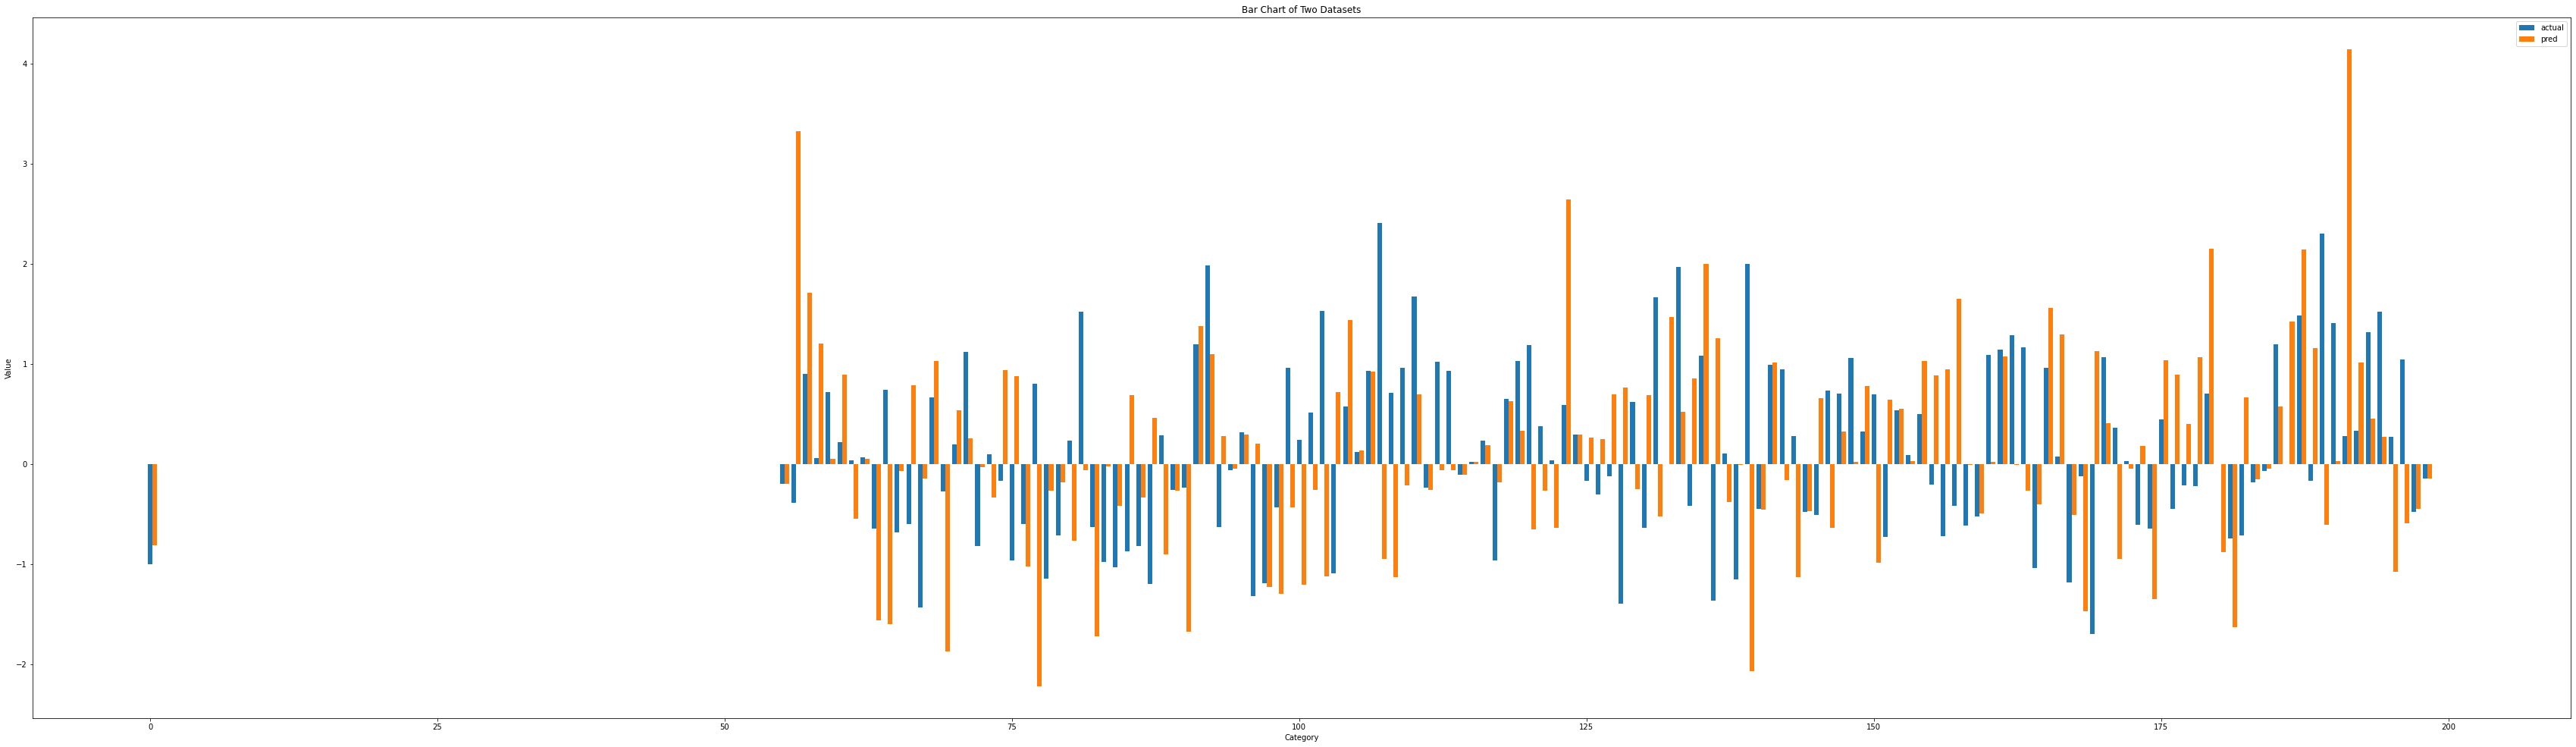

In [235]:
import numpy as np
import matplotlib.pyplot as plt

# Generate two sets of random data
# actual = testing_data.ss_data.inverse_transform(X_test)[26][25:]
# predict = testing_data.ss_labels.inverse_transform(y_test)[27][25:]

actual =(X_test)[26]
predict =(y_test)[27]

# Define the x-axis labels
labels = np.arange(0,201)

# Set the width of each bar
width = .4
p = plt.figure(figsize=(60,17))

# Plot the bar charts
plt.bar(labels, actual, width, label='actual')
plt.bar([x + width for x in range(len(labels))], predict, width, label='pred')

# Add a legend and axis labels
plt.legend(loc='upper right')
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Bar Chart of Two Datasets')

# Show the plot
plt.show()


In [236]:
X_test.shape

torch.Size([48, 201])

In [237]:
y_test.shape

torch.Size([48, 201])

In [241]:
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd

# create sample data
df = pd.DataFrame({
    'bins': np.arange(0,201),
    'real': X_test[0],
    'predict': y_test[1]
})

# create traces for the two bar charts
trace1 = go.Bar(x=df['bins'], y=df['real'], name='real')
trace2 = go.Bar(x=df['bins'], y=df['predict'], name='predict')

# create a data list containing the traces
data = [trace1, trace2]

# set the layout of the chart
layout = go.Layout(title='scaled at timestep 0 Bar Chart')

# create the figure object
fig = go.Figure(data=data, layout=layout)

# plot the figure and show the chart in an interactive HTML file
pyo.plot(fig, filename='scaled0.html')


'scaled0.html'

In [240]:
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd

# create sample data
df2 = pd.DataFrame({
    'bins': np.arange(0,201),
    'real': testing_data.ss_data.inverse_transform(X_test)[0],
    'predict': testing_data.ss_labels.inverse_transform(y_test)[1]
})

# create traces for the two bar charts
trace1 = go.Bar(x=df2['bins'], y=df2['real'], name='real')
trace2 = go.Bar(x=df2['bins'], y=df2['predict'], name='predict')

# create a data list containing the traces
data = [trace1, trace2]

# set the layout of the chart
layout = go.Layout(title='unscaled time step 0 Bar Chart')

# create the figure object
fig = go.Figure(data=data, layout=layout)

# plot the figure and show the chart in an interactive HTML file
pyo.plot(fig, filename='unscaled0.html')


'unscaled0.html'

In [205]:
df2.head()

,bins,real,predict
0,0,"(tensor(0.4994, dtype=torch.float64), tensor(0...","(tensor(-0.1569, dtype=torch.float64), tensor(..."
1,1,"(tensor(-0.1584, dtype=torch.float64), tensor(...","(tensor(1.1596, dtype=torch.float64), tensor(0..."
2,2,"(tensor(1.1573, dtype=torch.float64), tensor(0...","(tensor(0.7939, dtype=torch.float64), tensor(0..."
3,3,"(tensor(0.7918, dtype=torch.float64), tensor(0...","(tensor(1.0133, dtype=torch.float64), tensor(0..."
4,4,"(tensor(1.0111, dtype=torch.float64), tensor(0...","(tensor(-1.3638, dtype=torch.float64), tensor(..."


In [189]:
y_test[0]

tensor([-0.1569,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1974,
        -0.3869, -0.6135, -0.6733, -0.2796, -0.0963,  2.3677,  0.0496,  0.0431,
         0.1209,  0.2099,  1.1275,  0.8055, -0.0447,  2.4236,  0.1881, -1.3485,
         0.3657, -0.3348,  0.5591, -0.3267, -0.1771,  1.2311,  1.1549, -1.7568,
         0.2409, -0.0593, -0.6338,  1.3170,  0.1911, -0.3765,  1.8081,  2.1218,
         0.8788, -0.9865,  0.4798, -1.2301,  0.2042,  2.0630, -0.0488,  1.1860,
         0.2030,  0.3644, -0.4330, -1.13

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.94381315, -1.40791058, -0.872008  , -0.33610543,  0.19979715,
         0.73569973,  1.2716023 ,  1.80750488,  2.34340745,  2.87931003,
         3.4152126 ]),
 <a list of 201 BarContainer objects>)

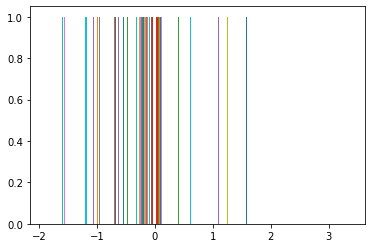

In [93]:
plt.hist(X_test[0])
plt.hist(y_test[1])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.03327789, -1.53865514, -1.04403239, -0.54940965, -0.0547869 ,
         0.43983585,  0.9344586 ,  1.42908134,  1.92370409,  2.41832684,
         2.91294959]),
 <a list of 201 BarContainer objects>)

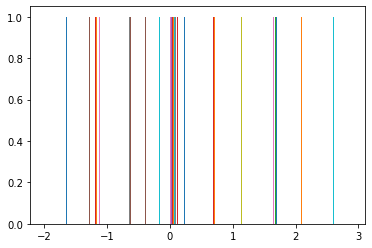

In [109]:
plt.hist(y_test[0])

In [85]:
len(X_test[0])

201

In [ ]:
# Define the hyperparameter search space
from ray import tune

config_space = {
    "hidden_size": tune.choice([64, 128, 256]),
    "num_layers": tune.choice([1, 2, 3]),
    "dropout": tune.uniform(0.1, 0.5),
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_epochs": 10
}

# Launch the Ray Tune experiment
analysis = tune.run(
    model,
    config=config_space,
    num_samples=10,
    search_alg=tune.suggest.hyperopt,
    metric="mean_accuracy",
    mode="max"
)

In [ ]:
tuner = tune.Tuner(
    train_mnist,
    param_space = {
    'batch_size': tune.choice([5, 10, 20]),
    'hidden_dim': tune.choice([32, 64, 128]),
    'num_hidden_layers': tune.choice([1, 2, 3, 4, 5]),
    'learning_rate': tune.choice([1e-6, 1e-5, 1e-4, 1e-3]),
    'weight_decay': tune.choice([1e-6, 1e-5, 1e-4, 1e-3]),
    'epoch_num': tune.choice([50, 100, 120, 150, 180, 200, 400]) },
    tune_config=tune.TuneConfig(
            metric="loss",
            mode="min")
)
analysis = tuner.fit()
print("Best config: ", analysis.get_best_result("mean_loss","min"))